<a href="https://colab.research.google.com/github/HYF0053/cloud_image_classification/blob/main/pic_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 安裝lib

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install pillow

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-4q3xdb2b
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-4q3xdb2b
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install opencv-python ftfy regex tqdm

# 圖片或影片跟文字的相似度


In [ ]:
import torch
import clip
from PIL import Image

# 加載模型
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)



100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 145MiB/s]


In [ ]:
# 加載並預處理圖片
image_path = "images.jpg"  # 替換成你圖片的路徑
image = Image.open(image_path)
image_input = preprocess(image).unsqueeze(0).to(device)

# 定義可能的文本描述
text_descriptions = [
    "hand in red circle",
    "hand not in red circle"

]
text_inputs = torch.cat([clip.tokenize(desc) for desc in text_descriptions]).to(device)

# 計算圖片和文本特徵
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# 計算圖片和每個文本描述之間的相似性
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (image_features @ text_features.T).squeeze(0)

# 找到最相似的描述
best_match = text_descriptions[similarity.argmax().item()]
print(best_match)

waving left hand


In [ ]:
import torch
import clip
from PIL import Image
import cv2
import numpy as np

# 加载CLIP模型
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# 定义可能的文本描述
text_descriptions = [
    "hand in red circle",
    "hand not in red circle"
    ]
text_inputs = torch.cat([clip.tokenize(desc) for desc in text_descriptions]).to(device)

# 打开camera
cap = cv2.VideoCapture("/home/user/UCF-101/HandstandWalking/v_HandstandWalking_g08_c02.avi")

frame_count = 0
frame_interval = 1  # 每隔帧处理一帧
similarity_threshold = 0.23  # 设置相似度阈值
accumulated_similarity = torch.zeros(len(text_descriptions), device=device)
window_size = 1  # 考虑的帧数

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_count += 1
    if frame_count % frame_interval == 0:
        # 将帧转换为PIL图像
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        # 预处理图片并计算特征
        image_input = preprocess(image).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image_input)
        # 计算图片和每个文本描述之间的相似性
        image_features /= image_features.norm(dim=-1, keepdim=True)
        with torch.no_grad():
            text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (image_features @ text_features.T).squeeze(0)
        # 累积相似度
        accumulated_similarity += similarity
        # 每 window_size 帧后进行判断
        if frame_count % (frame_interval * window_size) == 0:
            # 计算平均相似度
            avg_similarity = accumulated_similarity / window_size
            #print(avg_similarity)
            # 找到最相似的前五个描述
            top_k = 5
            top_k_indices = avg_similarity.topk(top_k).indices
            best_matches = [text_descriptions[i] for i in top_k_indices]

            # 确认相似度是否高于阈值
            if avg_similarity[top_k_indices[0]] < similarity_threshold:
                display_text = "Action not recognized"
            else:
                display_text = ', '.join(best_matches)

            print(f"Frame {frame_count}: {display_text}")

            cv2.putText(frame, best_matches[0], (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 1, cv2.LINE_AA)
            cv2.putText(frame, best_matches[1], (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 1, cv2.LINE_AA)
            cv2.putText(frame, best_matches[2], (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 1, cv2.LINE_AA)
            cv2.imshow("Action Recognition", frame)

            # 重置累积相似度
            accumulated_similarity = torch.zeros(len(text_descriptions), device=device)

        if cv2.waitKey(1) == ord('q'): # 按 'q' 键退出
            break

cap.release()
cv2.destroyAllWindows()

Frame 2: shaking hands
Frame 4: shaking hands
Frame 6: standing
Frame 8: shaking hands
Frame 10: shaking hands
Frame 12: shaking hands
Frame 14: shaking hands
Frame 16: shaking hands
Frame 18: shaking hands
Frame 20: shaking hands
Frame 22: shaking hands
Frame 24: hit with object
Frame 26: standing
Frame 28: shaking hands
Frame 30: shaking hands
Frame 32: shaking hands
Frame 34: shaking hands


# 圖片依照種類分類

In [ ]:
import torch
import clip
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 加载模型
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# 加载图像并进行预处理
def load_and_preprocess_image(image_path):
    image = Image.open(image_path)
    image = preprocess(image).unsqueeze(0).to(device)
    return image

# 计算图像特征
def get_image_features(image):
    with torch.no_grad():
        image_features = model.encode_image(image)
    return image_features

# 加载并处理图像
image_paths = ["/content/dog.png", "/content/images.jfif","/content/dog2.jfif"]  # 确保至少有4张图像
images = [load_and_preprocess_image(image_path) for image_path in image_paths]
image_features = [get_image_features(image) for image in images]

# 将特征转换为NumPy数组
features_array = np.array([features.cpu().numpy() for features in image_features]).squeeze()

# 检查数据是否属于一个类别
def is_single_category(features_array, threshold=1e-4):
    distances = np.linalg.norm(features_array - features_array.mean(axis=0), axis=1)
    return np.all(distances < threshold)

# 自适应聚类，选择最佳聚类数量
def find_optimal_clusters(data, max_clusters):
    best_n_clusters = 2
    best_score = -1
    for n_clusters in range(2, min(max_clusters + 1, len(data))):
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
        score = silhouette_score(data, kmeans.labels_)
        if score > best_score:
            best_score = score
            best_n_clusters = n_clusters
    return best_n_clusters

# 检查是否需要进行聚类
if is_single_category(features_array):
    optimal_clusters = 1
else:
    # 设置最大可能的聚类数量（可以根据需要调整）
    max_clusters = 10
    optimal_clusters = find_optimal_clusters(features_array, max_clusters)

# 输出聚类结果
if optimal_clusters == 1:
    print("All images are in a single category")
    for i, image_path in enumerate(image_paths):
        print(f"Image {image_path} is in cluster 0")
else:
    # 使用最佳聚类数量进行KMeans聚类
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=0).fit(features_array)
    for i, label in enumerate(kmeans.labels_):
        print(f"Image {image_paths[i]} is in cluster {label}")

Image /content/dog.png is in cluster 0
Image /content/images.jfif is in cluster 1
Image /content/dog2.jfif is in cluster 0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# 依文字找出圖片

In [ ]:
import torch
import clip
from PIL import Image
import numpy as np

# 加载CLIP模型
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# 加载图像并进行预处理
def load_and_preprocess_image(image_path):
    image = Image.open(image_path)
    image = preprocess(image).unsqueeze(0).to(device)
    return image

# 计算图像特征
def get_image_features(image):
    with torch.no_grad():
        image_features = model.encode_image(image)
    return image_features

# 计算文本特征
def get_text_features(text):
    text_tokens = clip.tokenize([text]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
    return text_features

# 计算图像与文本的相似度
def calculate_similarity(image_features, text_features):
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    similarity = torch.matmul(image_features, text_features.T)
    return similarity.cpu().numpy()

# 图像路径列表
image_paths = ["/content/dog.png","/content/dog2.jfif","/content/images.jfif","/content/gecko.png","/content/jbBLrWS.png"]  # 替换为你的图像路径

# 加载并处理图像
images = [load_and_preprocess_image(image_path) for image_path in image_paths]
image_features = torch.cat([get_image_features(image) for image in images])

# 输入文本
input_text = input("text input : ")  # 替换为你的文本描述
text_features = get_text_features(input_text)

# 计算相似度
similarity_scores = calculate_similarity(image_features, text_features)

# 找出最相似的图像
top_k = 3  # 选择最相似的k张图像
top_k_indices = similarity_scores.flatten().argsort()[-top_k:][::-1]
# 设置相似度阈值
similarity_threshold = 0.24  # 替换为你认为合适的阈值
# 输出最相似的图像路径，如果没有满足相似度阈值的图像，则输出未找到相似图像的提示
found_match = False
for idx in top_k_indices:
    if similarity_scores[idx] >= similarity_threshold:
        print(f"Image {image_paths[idx]} is similar to the input text with similarity score {similarity_scores[idx]}")
        found_match = True

if not found_match:
    print("No image is similar to the input text")

text input : machine
Image /content/jbBLrWS.png is similar to the input text with similarity score [0.24093032]


# drive的改寫

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


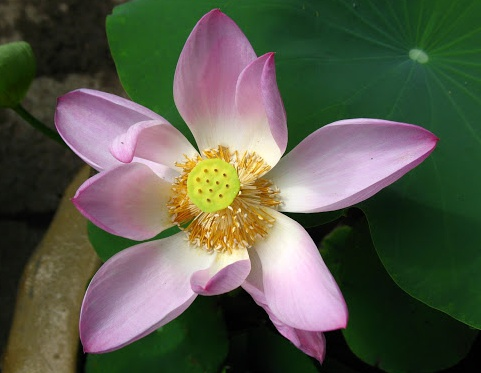

In [ ]:
import os
from PIL import Image

# 定义图片文件夹路径
image_folder = '/content/drive/MyDrive/img_test'

# 读取文件夹中的所有图片
image_paths = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith(('jpg', 'jpeg', 'png'))]

# 加载图片
images = [Image.open(image_path) for image_path in image_paths]

# 显示第一张图片作为示例
display(images[0])

文字找圖但不儲存

In [ ]:
import torch
import clip
from PIL import Image
import numpy as np
from google.colab import drive
import os
import matplotlib.pyplot as plt

# 加载CLIP模型
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# 加载图像并进行预处理
def load_and_preprocess_image(image_path):
    image = Image.open(image_path)
    image = preprocess(image).unsqueeze(0).to(device)
    return image

# 计算图像特征
def get_image_features(image):
    with torch.no_grad():
        image_features = model.encode_image(image)
    return image_features

# 计算文本特征
def get_text_features(text):
    text_tokens = clip.tokenize([text]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
    return text_features

# 计算图像与文本的相似度
def calculate_similarity(image_features, text_features):
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    similarity = torch.matmul(image_features, text_features.T)
    return similarity.cpu().numpy()

# 定义图片文件夹路径
image_folder = '/content/drive/MyDrive/samll'

# 读取文件夹中的所有图片
image_paths = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith(('jpg', 'jpeg', 'png'))]

# 加载图片
images = [load_and_preprocess_image(image_path) for image_path in image_paths]
image_features = torch.cat([get_image_features(image) for image in images])

# 输入文本
input_text = input("text input : ")  # 替换为你的文本描述
text_features = get_text_features(input_text)

# 计算相似度
similarity_scores = calculate_similarity(image_features, text_features)

# 找出最相似的图像
top_k = 10  # 选择最相似的k张图像
top_k_indices = similarity_scores.flatten().argsort()[-top_k:][::-1]
# 设置相似度阈值
similarity_threshold = 0.24  # 替换为你认为合适的阈值
# 输出最相似的图像路径，如果没有满足相似度阈值的图像，则输出未找到相似图像的提示
found_match = False
top_images = []
for idx in top_k_indices:
    if similarity_scores[idx] >= similarity_threshold:
        print(f"Image {image_paths[idx]} is similar to the input text with similarity score {similarity_scores[idx]}")
        found_match = True
        top_images.append(Image.open(image_paths[idx]))

if not found_match:
    print("No image is similar to the input text")
else:
    # 显示top k相似的图片
    fig, axs = plt.subplots(1, top_k, figsize=(15, 5))
    for i, img in enumerate(top_images):
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 81.5MiB/s]


text input : cat
No image is similar to the input text


文字找圖且儲存

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
text input: cat
output file name: cat
Image /content/drive/MyDrive/img_test/cat_0049.jpg is similar to the input text with similarity score [0.28144658]
Image /content/drive/MyDrive/img_test/cat_0041.jpg is similar to the input text with similarity score [0.2725047]
Image /content/drive/MyDrive/img_test/cat_0002.jpg is similar to the input text with similarity score [0.26969314]


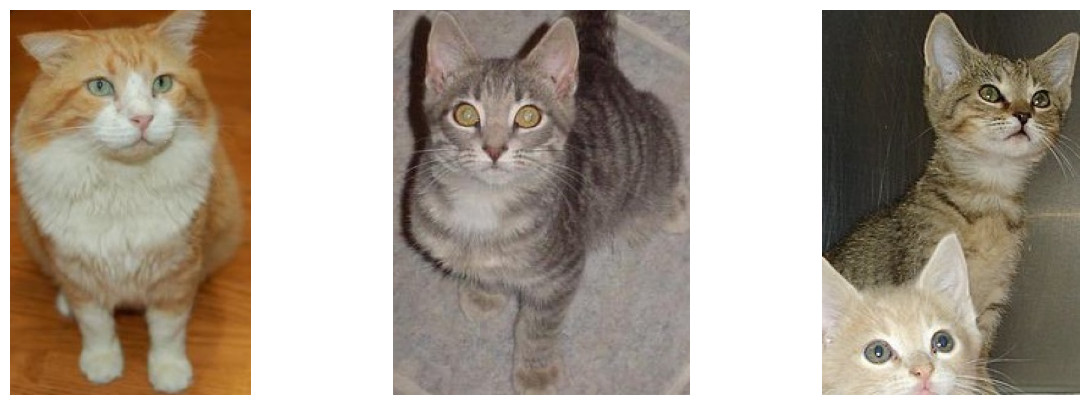

In [ ]:
import torch
import clip
from PIL import Image
import numpy as np
from google.colab import drive
import os
import matplotlib.pyplot as plt

# 挂载Google Drive
drive.mount('/content/drive')

# 加载CLIP模型
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# 加载图像并进行预处理
def load_and_preprocess_image(image_path):
    image = Image.open(image_path)
    image = preprocess(image).unsqueeze(0).to(device)
    return image

# 计算图像特征
def get_image_features(image):
    with torch.no_grad():
        image_features = model.encode_image(image)
    return image_features

# 计算文本特征
def get_text_features(text):
    text_tokens = clip.tokenize([text]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
    return text_features

# 计算图像与文本的相似度
def calculate_similarity(image_features, text_features):
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    similarity = torch.matmul(image_features, text_features.T)
    return similarity.cpu().numpy()

# 输入文本
input_text = input("text input: ")  # 替换为你的文本描述
output_file = input("output file name: ")
text_features = get_text_features(input_text)

# Google Drive中的图像文件夹路径
image_folder = '/content/drive/MyDrive/img_test'  # 替换为你的图像文件夹路径

# 读取文件夹中的所有图片
image_paths = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith(('jpg', 'jpeg', 'png', 'jfif'))]

# 加载并处理图像
images = [load_and_preprocess_image(image_path) for image_path in image_paths]
image_features = torch.cat([get_image_features(image) for image in images])

# 计算相似度
similarity_scores = calculate_similarity(image_features, text_features)

# 找出最相似的图像
top_k = 3  # 选择最相似的k张图像
top_k_indices = similarity_scores.flatten().argsort()[-top_k:][::-1]

# 设置相似度阈值
similarity_threshold = 0.24  # 替换为你认为合适的阈值

# 创建新的文件夹
processed_image_folder = '/content/drive/MyDrive/' + output_file
os.makedirs(processed_image_folder, exist_ok=True)

# 输出最相似的图像路径和显示图像
found_match = False
top_images = []
for idx in top_k_indices:
    if similarity_scores[idx] >= similarity_threshold:
        print(f"Image {image_paths[idx]} is similar to the input text with similarity score {similarity_scores[idx]}")
        found_match = True
        top_images.append(Image.open(image_paths[idx]))
        # 保存相似的图像到新文件夹
        save_path = os.path.join(processed_image_folder, os.path.basename(image_paths[idx]))
        Image.open(image_paths[idx]).save(save_path)

if not found_match:
    print("No image is similar to the input text")
else:
    # 显示top k相似的图片
    fig, axs = plt.subplots(1, top_k, figsize=(15, 5))
    for i, img in enumerate(top_images):
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()

以圖搜圖並儲存

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
output file name: similar
Image /content/drive/MyDrive/samll/motorbike_0009.jpg is similar to the input text with similarity score [0.7860713]
Image /content/drive/MyDrive/samll/motorbike_0005.jpg is similar to the input text with similarity score [0.77722657]
Image /content/drive/MyDrive/samll/motorbike_0006.jpg is similar to the input text with similarity score [0.7733164]


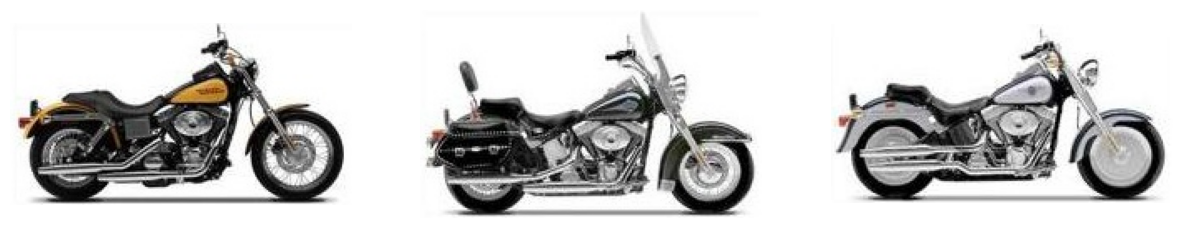

In [ ]:
import torch
import clip
from PIL import Image
import numpy as np
from google.colab import drive
import os
import matplotlib.pyplot as plt

# 挂载Google Drive
drive.mount('/content/drive')

# 加载CLIP模型
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# 加载图像并进行预处理
def load_and_preprocess_image(image_path):
    image = Image.open(image_path)
    image = preprocess(image).unsqueeze(0).to(device)
    return image

# 计算图像特征
def get_image_features(image):
    with torch.no_grad():
        image_features = model.encode_image(image)
    return image_features


# 计算图像与文本的相似度
def calculate_similarity(image_features, text_features):
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    similarity = torch.matmul(image_features, text_features.T)
    return similarity.cpu().numpy()

# Google Drive中的图像文件夹路径
image_folder = '/content/drive/MyDrive/samll'  # 替换为你的图像文件夹路径

# 读取文件夹中的所有图片
image_paths = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith(('jpg', 'jpeg', 'png', 'jfif'))]

# 加载并处理图像
images = [load_and_preprocess_image(image_path) for image_path in image_paths]
image_features = torch.cat([get_image_features(image) for image in images])

# 输入比較圖
output_file = input("output file name: ")
image_path = "/content/bike.jpg" #要尋找相似的圖
image_sim = load_and_preprocess_image(image_path)
sim_features = get_image_features(image_sim)

# 计算相似度
similarity_scores = calculate_similarity(image_features, sim_features)

# 找出最相似的图像
top_k = 3  # 选择最相似的k张图像
top_k_indices = similarity_scores.flatten().argsort()[-top_k:][::-1]

# 设置相似度阈值
similarity_threshold = 0.24  # 替换为你认为合适的阈值

# 创建新的文件夹
processed_image_folder = '/content/drive/MyDrive/' + output_file
os.makedirs(processed_image_folder, exist_ok=True)

# 输出最相似的图像路径和显示图像
found_match = False
top_images = []
for idx in top_k_indices:
    if similarity_scores[idx] >= similarity_threshold:
        print(f"Image {image_paths[idx]} is similar to the input text with similarity score {similarity_scores[idx]}")
        found_match = True
        top_images.append(Image.open(image_paths[idx]))
        # 保存相似的图像到新文件夹
        save_path = os.path.join(processed_image_folder, os.path.basename(image_paths[idx]))
        Image.open(image_paths[idx]).save(save_path)

if not found_match:
    print("No image is similar to the input text")
else:
    # 显示top k相似的图片
    fig, axs = plt.subplots(1, top_k, figsize=(15, 5))
    for i, img in enumerate(top_images):
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()

圖片分類並儲存

In [ ]:
import torch
import clip
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from google.colab import drive
import os
import shutil

# 挂载Google Drive
drive.mount('/content/drive')

# 加载CLIP模型
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# 加载图像并进行预处理
def load_and_preprocess_image(image_path):
    image = Image.open(image_path)
    image = preprocess(image).unsqueeze(0).to(device)
    return image

# 计算图像特征
def get_image_features(image):
    with torch.no_grad():
        image_features = model.encode_image(image)
    return image_features

# Google Drive中的图像文件夹路径
image_folder = '/content/drive/MyDrive/samll'  # 替换为你的图像文件夹路径

# 读取文件夹中的所有图片
image_paths = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith(('jpg', 'jpeg', 'png', 'jfif'))]

# 加载并处理图像
images = [load_and_preprocess_image(image_path) for image_path in image_paths]
image_features = torch.cat([get_image_features(image) for image in images])

# 将特征转换为NumPy数组
features_array = np.array([features.cpu().numpy() for features in image_features]).squeeze()

# 检查数据是否属于一个类别
def is_single_category(features_array, threshold=1e-4):
    distances = np.linalg.norm(features_array - features_array.mean(axis=0), axis=1)
    return np.all(distances < threshold)

# 自适应聚类，选择最佳聚类数量
def find_optimal_clusters(data, max_clusters):
    best_n_clusters = 2
    best_score = -1
    for n_clusters in range(2, min(max_clusters + 1, len(data))):
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
        score = silhouette_score(data, kmeans.labels_)
        if score > best_score:
            best_score = score
            best_n_clusters = n_clusters
    return best_n_clusters

# 创建新的文件夹以保存分类后的图像
output_folder = '/content/drive/MyDrive/clustered_images'
os.makedirs(output_folder, exist_ok=True)

# 检查是否需要进行聚类
if is_single_category(features_array):
    optimal_clusters = 1
else:
    # 设置最大可能的聚类数量（可以根据需要调整）
    max_clusters = 3
    optimal_clusters = find_optimal_clusters(features_array, max_clusters)

# 输出聚类结果并将图片保存到相应的文件夹
if optimal_clusters == 1:
    print("All images are in a single category")
    cluster_folder = os.path.join(output_folder, 'cluster_0')
    os.makedirs(cluster_folder, exist_ok=True)
    for i, image_path in enumerate(image_paths):
        print(f"Image {image_path} is in cluster 0")
        shutil.copy(image_path, os.path.join(cluster_folder, os.path.basename(image_path)))
else:
    # 使用最佳聚类数量进行KMeans聚类
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=0).fit(features_array)
    for i, label in enumerate(kmeans.labels_):
        cluster_folder = os.path.join(output_folder, f'cluster_{label}')
        os.makedirs(cluster_folder, exist_ok=True)
        print(f"Image {image_paths[i]} is in cluster {label}")
        shutil.copy(image_paths[i], os.path.join(cluster_folder, os.path.basename(image_paths[i])))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image /content/drive/MyDrive/samll/motorbike_0005.jpg is in cluster 1
Image /content/drive/MyDrive/samll/motorbike_0008.jpg is in cluster 1
Image /content/drive/MyDrive/samll/fruit_0009.jpg is in cluster 2
Image /content/drive/MyDrive/samll/motorbike_0000.jpg is in cluster 1
Image /content/drive/MyDrive/samll/fruit_0004.jpg is in cluster 2
Image /content/drive/MyDrive/samll/motorbike_0003.jpg is in cluster 1
Image /content/drive/MyDrive/samll/motorbike_0004.jpg is in cluster 1
Image /content/drive/MyDrive/samll/fruit_0002.jpg is in cluster 2
Image /content/drive/MyDrive/samll/fruit_0006.jpg is in cluster 2
Image /content/drive/MyDrive/samll/fruit_0008.jpg is in cluster 2
Image /content/drive/MyDrive/samll/fruit_0005.jpg is in cluster 2
Image /content/drive/MyDrive/samll/fruit_0007.jpg is in cluster 2
Image /content/drive/MyDrive/samll/motorbike_0002.jpg is in cluster 1
Image /content/drive/MyDrive/samll/motorbike_0006.jpg is in cluster 1
Image /content/drive/MyDrive/samll/motorbike_000